In [ ]:
!pip install torchsummary


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
import warnings
import networkx as nx
from collections import Counter
from tqdm import tqdm  
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.ndimage import zoom
from skimage.transform import resize
import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Slider
from ipywidgets import interact, IntSlider,fixed
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50
from torchsummary import summary
from skimage.transform import resize
import json

In [ ]:
data_dir='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

In [ ]:
label_coordinates='/kaggle/input/mmd-ai-rsna2024-coordination-label-saving/data_with_condition_one_hot.json'

In [ ]:
import openpyxl
!pip install natsort 
from natsort import natsorted

In [ ]:
data_dir='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

**Visualizeing images**

In [ ]:
dicom_file_path = f'{data_dir}/train_images/376723024/9334563'
dicom_files=os.listdir(dicom_file_path)
sorted_dicom=natsorted(dicom_files)
rows=4
cols=4
fig, axes = plt.subplots(rows,cols , figsize=(15, 10))
for i,dicom_file in enumerate(sorted_dicom):
    if i>=rows*cols:
        break
    dicom_file_paths = dicom_file_path + f'/{dicom_file}'
    
    dicom_data = pydicom.dcmread(dicom_file_paths)
    pixel_array = dicom_data.pixel_array
    ax = axes[i // cols, i % cols]
    ax.imshow(pixel_array, cmap='gray')
    ax.set_title(f'DICOM Image: {dicom_file}',fontsize=8)
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [ ]:

# Load the CSV file
file_path = f'{data_dir}/train_series_descriptions.csv'
file_path_train = f'{data_dir}/train.csv'
file_path_train_label_coordinates = f'{data_dir}/train_label_coordinates.csv'

train_series_descriptions = pd.read_csv(file_path)
train=pd.read_csv(file_path_train)
train_label_coordinates=pd.read_csv(file_path_train_label_coordinates)

# Display the first few rows of the dataframe
train_series_descriptions.head()


In [ ]:
unique_series_id=np.sort(train_label_coordinates['series_id'].unique())


In [ ]:
train.head()

In [ ]:
train_label_coordinates.head()
unique_conditions = train_label_coordinates['condition'].unique()
unique_conditions

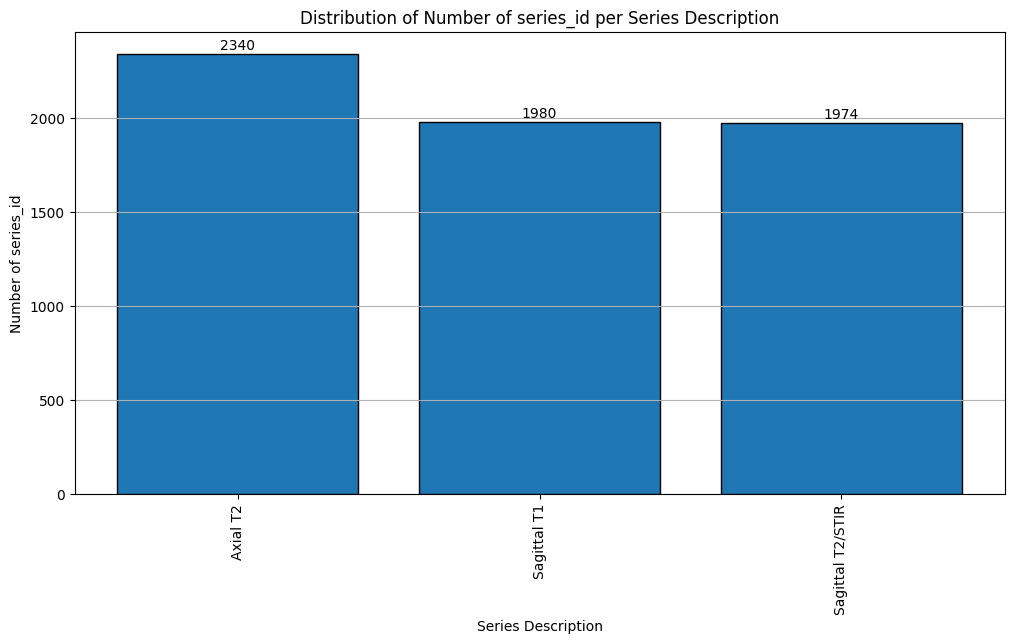

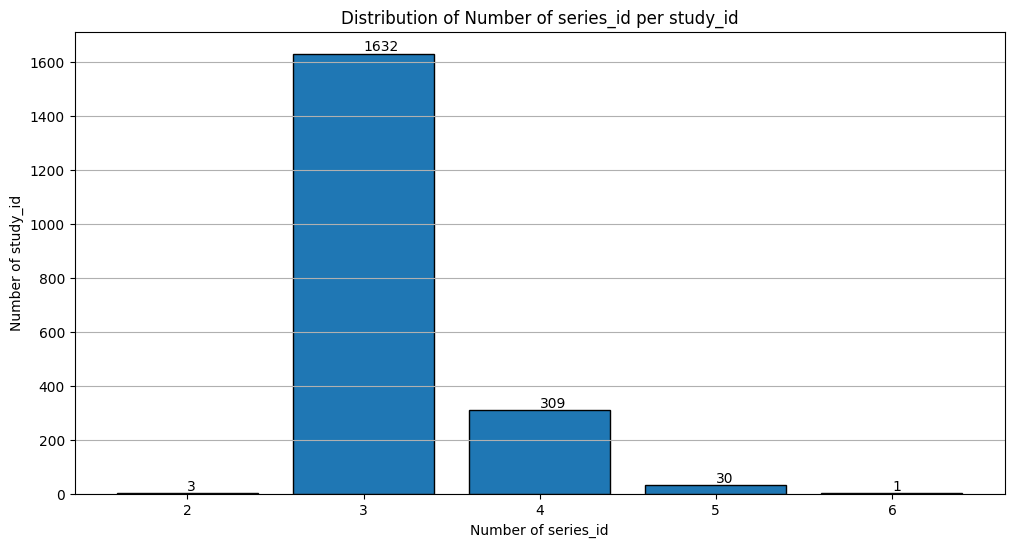

subject ids without all 3 modalities:[2492114990, 2780132468, 3008676218]


In [ ]:
# Adjust the code to display the number of study_ids on the bars
series_count_per_study = train_series_descriptions.groupby('study_id')['series_id'].count().reset_index()
series_count_per_study.columns = ['study_id', 'series_count']

series_count = series_count_per_study['series_count'].value_counts()

plt.figure(figsize=(12, 6))
bars = plt.bar(series_count.index, series_count.values, edgecolor='black')

# Add text labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xlabel('Number of series_id')
plt.ylabel('Number of study_id')
plt.title('Distribution of Number of series_id per study_id')
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
# Calculate the number of series_id for each series_description
series_count_per_description = train_series_descriptions['series_description'].value_counts().reset_index()
series_count_per_description.columns = ['series_description', 'series_count']

# Create a discrete plot (bar plot) for the number of series_id each series_description has
plt.figure(figsize=(12, 6))
bars = plt.bar(series_count_per_description['series_description'],
               series_count_per_description['series_count'],
               edgecolor='black')
plt.xlabel('Series Description')
plt.ylabel('Number of series_id')
plt.title('Distribution of Number of series_id per Series Description')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Add text labels on the bars with better visibility
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom')  # ha: horizontal alignment, va: vertical alignment

# Show the plot
plt.show()

In [ ]:
# Define the base directory containing the patient folders
base_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Dictionary to hold the count of DICOM files per series ID
series_dicom_count = Counter()

# Traverse the directory structure
for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    if os.path.isdir(patient_path):
        for series_folder in os.listdir(patient_path):
            series_path = os.path.join(patient_path, series_folder)
            if os.path.isdir(series_path):
                dicom_files = [f for f in os.listdir(series_path) if f.endswith('.dcm')]
                series_dicom_count[series_folder] = len(dicom_files)



# Create the plot
dicom_counts = list(series_dicom_count.values())
plt.figure(figsize=(12, 6))
plt.hist(dicom_counts, bins=range(min(dicom_counts), max(dicom_counts) + 1), edgecolor='black')
plt.xlabel('Number of slides (DICOM files)')
plt.ylabel('Number of series ID')
plt.title('Distribution of Number of DICOM Files per Series ID')
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
min_slides = np.min(dicom_counts)
max_slides = np.max(dicom_counts)
mean_slides = np.mean(dicom_counts)
print(min_slides)
print(max_slides)
print(mean_slides)

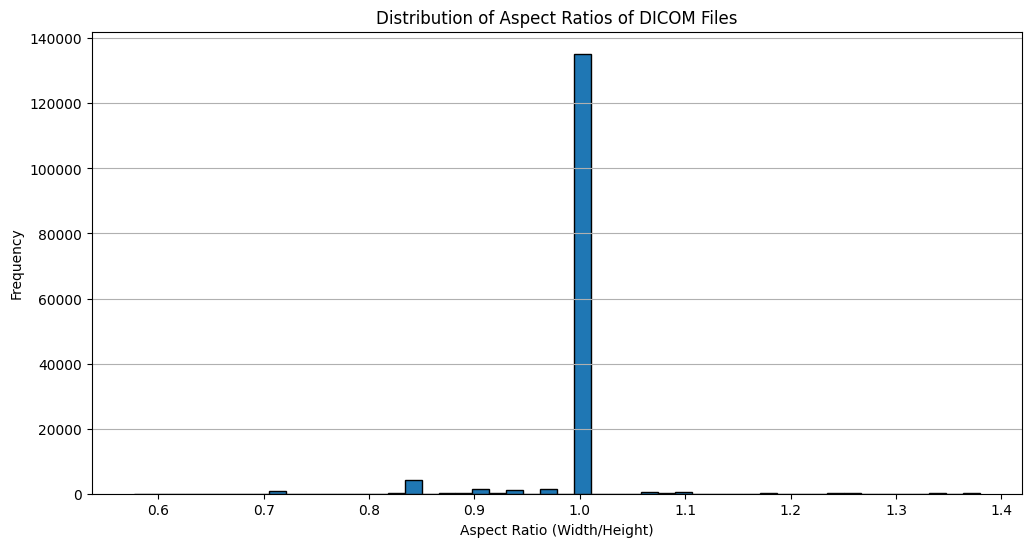
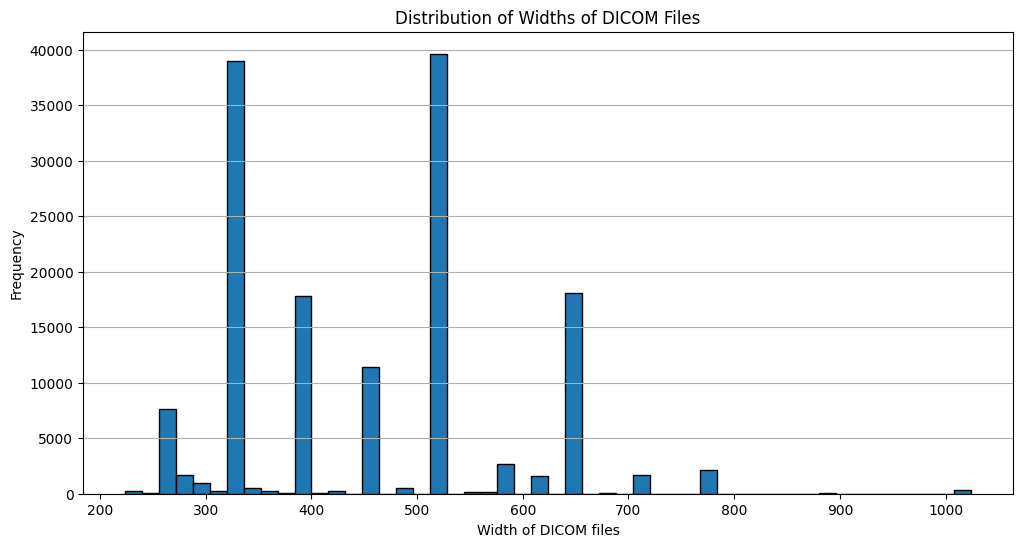
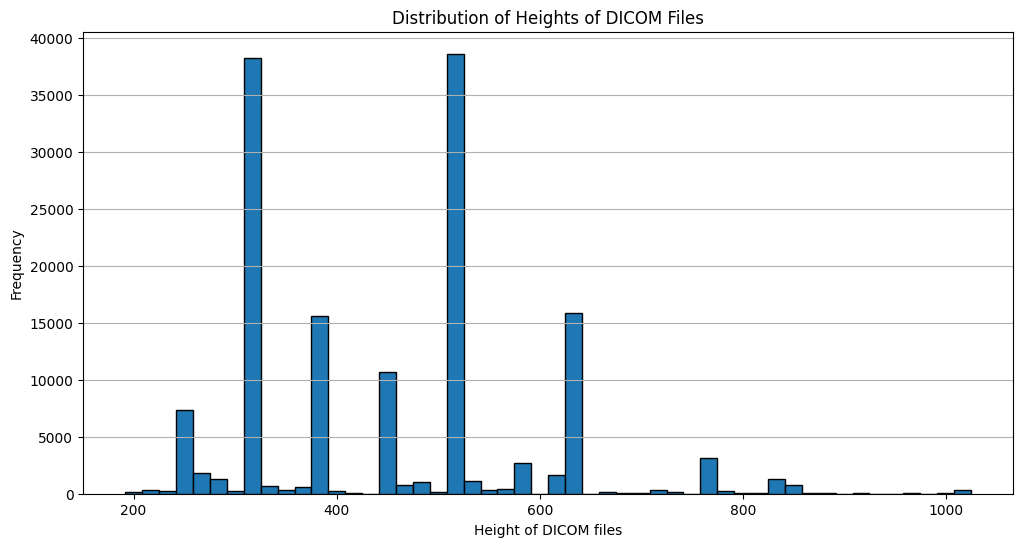

Minimum height: 192


Maximum height: 1024

Mean height: 451.52

Minimum width: 224

Maximum width: 1024

Mean width: 446.16

Minimum aspect ratio: 0.58

Maximum aspect ratio: 1.38

Mean aspect ratio: 0.99
 
min_slides = 5

max_slides = 192

mean_slides=23.9

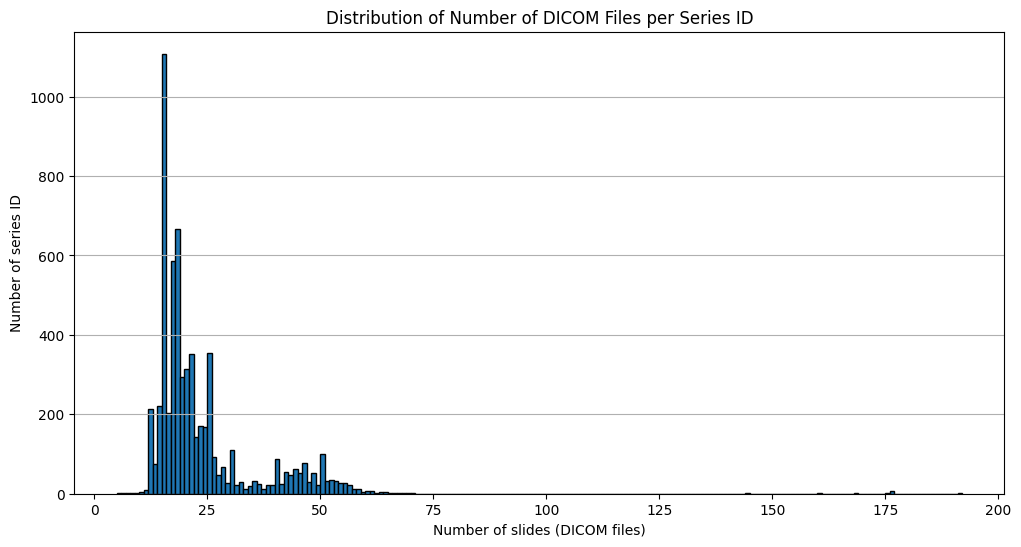

In [ ]:
# Calculate min, max, and mean for heights
min_height = np.min(heights)
max_height = np.max(heights)
mean_height = np.mean(heights)

# Calculate min, max, and mean for widths
min_width = np.min(widths)
max_width = np.max(widths)
mean_width = np.mean(widths)

# Calculate min, max, and mean for aspect ratios
min_aspect_ratio = np.min(aspect_ratios)
max_aspect_ratio = np.max(aspect_ratios)
mean_aspect_ratio = np.mean(aspect_ratios)

print(f"Minimum height: {min_height}")
print(f"Maximum height: {max_height}")
print(f"Mean height: {mean_height:.2f}")

print(f"Minimum width: {min_width}")
print(f"Maximum width: {max_width}")
print(f"Mean width: {mean_width:.2f}")

print(f"Minimum aspect ratio: {min_aspect_ratio:.2f}")
print(f"Maximum aspect ratio: {max_aspect_ratio:.2f}")
print(f"Mean aspect ratio: {mean_aspect_ratio:.2f}")


In [ ]:
# Pivot the table to check whether each study_id has at least one of each series_description
study_series_pivot = train_series_descriptions.pivot_table(index='study_id', columns='series_description', aggfunc='size', fill_value=0)

# Check if each study_id has at least one of each series_description
has_all_series_descriptions = (study_series_pivot > 0).all(axis=1)

# Calculate the number of study_ids that have at least one of each series_description
num_studies_with_all_series = has_all_series_descriptions.sum()

num_studies_with_all_series, has_all_series_descriptions.head()
# Calculate the total number of unique study_ids
total_study_ids = train_series_descriptions['study_id'].nunique()

# Calculate the number of study_ids that do not have at least one of each series_description
num_studies_without_all_series = total_study_ids - num_studies_with_all_series

print(num_studies_without_all_series)

missing_series_studies = has_all_series_descriptions[~has_all_series_descriptions].index

missing_series_studies.tolist()

In [ ]:
merged_data = pd.read_csv('/kaggle/input/merged-train/merged_train_label_coordinates.csv')

# Check the hypothesis: rows with 'Sagittal T2/STIR' in series_description have just 'Spinal Canal Stenosis' in condition
sagittal_t2_stir_conditions = merged_data[merged_data['series_description'] == 'Sagittal T2/STIR']['condition'].unique()

sagittal_t2_stir_conditions
unique_conditions_level = merged_data[merged_data['condition']=='Right Neural Foraminal Narrowing']['level'].unique()
unique_conditions_level

In [ ]:
sagittal_t1_conditions = merged_data[merged_data['series_description'] == 'Sagittal T1']['condition'].unique()

sagittal_t1_conditions

In [ ]:
sagittal_t1_spinal_canal_stenosis = merged_data[(merged_data['series_description'] == 'Sagittal T1') & 
                                                (merged_data['condition'] == 'Spinal Canal Stenosis')]

# Get unique series_id for these rows
sagittal_t1_spinal_canal_stenosis_series_ids = sagittal_t1_spinal_canal_stenosis['series_id'].unique()

sagittal_t1_spinal_canal_stenosis_series_ids

****array([3951475160]) is a sagital t1 but has spinal canal stenosis

In [ ]:
axial_t2_conditions = merged_data[merged_data['series_description'] == 'Axial T2']['condition'].unique()

axial_t2_conditions

In [ ]:
figure, axis = plt.subplots(1,3, figsize=(20,5)) 
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, train.columns))
    dff = train[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')


In [ ]:
print('done!')